## Instructions
- See deadline on the course web page
- This problem set is solved individually. See examination rules on the course web page and the explanation of the examination procedure below.
- The two notebooks for each problem set contain a number of basic and extra problems; you can choose which and how many to work on. The extra problems are usually more challenging.
- Students are allowed to discuss together and help each other when solving the problems. However, every student must understand their submitted solution in the sense that they should be able to explain and discuss them with a peer or with a teacher.
- While discussions with your peers are allowed (and even encouraged), direct plagiarism is not. Every student must reach their own understanding of submitted solutions according to the definition in the previous point.
- The use of coding assistance from code generating artificial intelligence tools is allowed. However, every student must reach their own understanding of submitted solutions (including employed algorithms) according to the definition above.
- Some problems include checkpoints in the form of `assert` statements. These usually check some basic functionality and you should make sure that your code passes these statements without raising an `AssertionError`. 
- Do not use other python modules than the ones included in the `environment.yml` file in the course github repo. 

- **Important:** The grading of problem sets requires **all** of the following actions:
  1. Make sure to always complete **Task 0** in the header part of the notebook and that this part does not raise any `AssertionError`(s).
  1. **Complete** the corresponding questions in Yata for every task that you have completed. This usually involves copying and pasting some code from your solution notebook and passing the code tests. You need to have a green check mark on Yata to get the corresponding points.
  1. **Upload** your solution in the form of your edited version of this Jupyter notebook via the appropriate assignment module in Canvas (separate for basic and extra tasks). It is the code and results in your submitted notebook that is considered to be your hand-in solution.
  1. If selected, be **available for a discussion** of your solution with one of the teachers on the Monday afternoon exercise session directly following the problem set deadline. No extra preparation is needed for these discussions apart from familiarity with your own solution. A list of randomly selected students will be published on the course web page around Monday noon. During the afternoon session that same day, students will be called in the numbered order until the end of the list (or the end of the exercise session). You must inform the responsible teacher as soon as possible following the publication of the student list if you can not be physically present at the exercise session (in which case we will have the discussion on zoom). An oral examination (on all aspects of the course) will be arranged during the exam week for students that do not show up for their discussion slot, or that fail to demonstrate familiarity with their hand-in solutions.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

- Make sure that the **run time is smaller than a few minutes**. If needed you might have to reduce some computational tasks; e.g. by decreasing the number of grid points or sampling steps. Please ask the supervisors if you are uncertain about the run time. 

- Your solutions are usually expected where it says `YOUR CODE HERE` or <font color="red">"PLEASE WRITE YOUR ANSWER HERE"</font>.

### Task 0 
#### (0 points)

By changing the below boolean variable `student_self_assessment` to `True` you attest that:
- All handed in solutions were produced by yourself in the sense that you understand your solutions and should be able to explain and discuss them with a peer or with a teacher.


In [1]:
student_self_assessment = False

# 
# YOUR CODE HERE
# 
student_self_assessment = True

In [2]:
assert student_self_assessment == True, 'You must assert the individual solution statements.'

# Problem Set 2 (Extra problems)
**Learning from data [TIF285], Chalmers, Fall 2025**

Last revised: 16-Sep-2025 by Christian Forssén [christian.forssen@chalmers.se]

In [3]:
import os
# Data files are stored in
DATA_DIR = "DataFiles/"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
# importing modules

import numpy as np
import matplotlib.pyplot as plt
#...

# 
# YOUR CODE HERE
# 
import scipy as scipy
import scipy.stats as stats
import pandas as pd
import emcee as emcee
import corner

## Problem 5: Signal and background (3 points)
The goal of this problem is to estimate the amplitude of a signal when there is a background.  We'll take a limiting case where the background is flat, so it is completely specified by its magnitude $B > 0$, and the signal is known to be a Gaussian with unknown amplitude $A$ but known position (mean) and width (standard deviation). 

The measurements will be integer numbers of counts $\{N_k\}$ in well-defined (equally spaced) bins $\{x_k\}$. The index $k$ runs over integers labeling the bins.

We can imagine three different goals of the data analysis:
- Finding $A$ and $B$ given $\{N_k\}$.
- Finding $A$ (we do not care about $B$).
- Finding $B$ (we do not care about $A$).

In all cases we consider the bin sizes and the signal shape (including its mean position and width) as known information.

Our statistical model includes the true signal plus a constant background. The signal and the background magnitudes are the unknown parameters while the other parameters dictating the signal (width $w$ and mean $x_0$ of the Gaussian) are known and fixed:

$$
   D_k = n_0 \left[ A e^{-(x_k-x_0)^2/2 w^2} + B \right]
$$

Here $n_0$ is a constant that scales with measurement time.  Note that $D_k$ is not an integer in general, unlike $N_k$.

In [5]:
# import statements.
# We use pickle to save and load a python dictionary
import pickle
# factorial from the math module is useful. You might consider other modules as well.
from math import factorial

# import additional modules as needed
# 
# YOUR CODE HERE
# 

In [6]:
# This function generates data according to the statistical model
A_true = 1.
B_true = 2.

def exact_data(A, B, n_0, x_k, x_0=0., width=np.sqrt(5.)):
    """
    Return the exact signal plus background.  The overall scale is n_0,
    which is determined by how long counts are collected. 
    The default signal position and width are 0.0 and sqrt(5), respectively (in some  irrelevant units).
    """

    return n_0 * (A * np.exp(-(x_k - x_0)**2/(2.*width**2)) + B)

### Poisson distribution
We are imagining a counting experiment, so the statistics of the counts we record will follow a Poisson distribution. It might be an interesting exercise to derive why this distribution is expected for a counting experiment. 

The Poisson discrete random variable from scipy.stats is defined by (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html))

$$
p(k \mid \mu) = \frac{\mu^k e^{-\mu}}{k!} \quad \mbox{for }k\geq 0 \;.
$$

where $k$ is an integer and $\mu$ is called the shape parameter. The mean and variance of this distribution are both equal to $\mu$. Sivia and Gregory each use a different notation for for this distribution, which means you need to be flexible. 

For convenience, we'll define our own version in this notebook:

$$
p(N \mid D) = \frac{D^N e^{-D}}{N!} \quad \mbox{for }N\geq 0 \;.
$$

where $N$ is an integer.

In [7]:
# make a dataset for exploring
def make_dataset(A_true, B_true, width, x_0, databins=15, delta_x=1, D_max=100):
    """
    Create a data set based on the number of bins (databins), the spacing
    of bins (delta_x), and the maximum we want the exact result to have
    (D_max, this fixes the n_0 parameter).
    
    Return arrays for the x points (xk_pts), the corresponding values of the
    exact signal plus background in those bins (Dk_pts), the measured values
    in those bins (Nk_pts, integers drawn from a Poisson distribution), the 
    maximum extent of the bins (x_max) and n_0.
    """
    # set up evenly spaced bins, centered on x_0
    x_max = x_0 + delta_x * (databins-1)/2
    xk_pts = np.arange(-x_max, x_max + delta_x, delta_x, dtype=int)
    
    # scale n_0 so maximum of the "true" signal plus background is D_max
    n_0 = D_max / (A_true + B_true)  
    Dk_pts = exact_data(A_true, B_true, n_0, xk_pts, width=width)
    
    # sample for each k to determine the measured N_k
    Nk_pts = [stats.poisson.rvs(mu=Dk) for Dk in Dk_pts]
    
    return xk_pts, Dk_pts, Nk_pts, x_max, n_0

### Plot the signal and the data (this plotting task is not graded, but will help you understand the data scenarios)
* Make a plot of the true signal plus background we are trying to deduce. Use $A_\mathrm{true}=1$ and $B_\mathrm{true}=2$ and the signal position (mean) $x_0=0$ and width (standard deviation)  $w=\sqrt{5}$.

We consider what happens for fixed signal and background but changing the experimental conditions specified by `D_max` and `databins` (we'll keep `delta_x` fixed to 1). In all cases the bins are symmetric around $x=0$.

The pickle file that is loaded in the cell below contains data from four differently designed counting experiments.:
1. Baseline case: 15 bins and maximum expection of 100 counts per bin.
1. Low statistics case: 15 bins and maximum expection of only 10 counts per bin.
1. Greater range case: 31 bins (with fixed bin width) and maximum expection of 50 counts per bin to give approximately the same total number of counts as in baseline case.
1. Smaller range case: 7 bins (with fixed bin width) and maximum expection of 200 counts per bin to give approximately the same total number of counts as in baseline case.
 
* Make four subplots that correspond to the data from the different experiments.

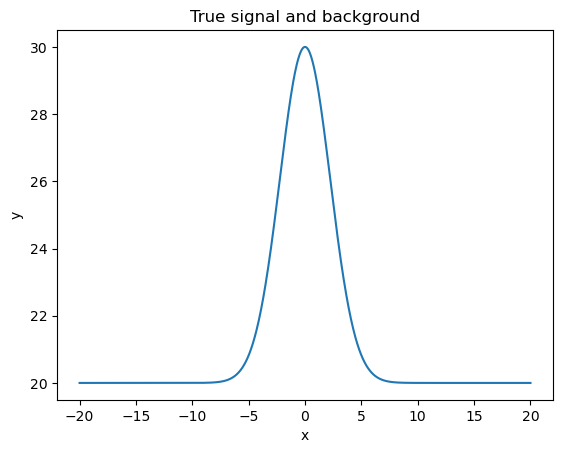

Loaded "data" dictionary from file.
Extract data with:
xk_pts, Dk_pts, Nk_pts, x_max, n_0 = data[case]
where the key "case" is one of:
dict_keys(['Baseline', 'Low Statistics', 'Greater Range', 'Smaller Range'])


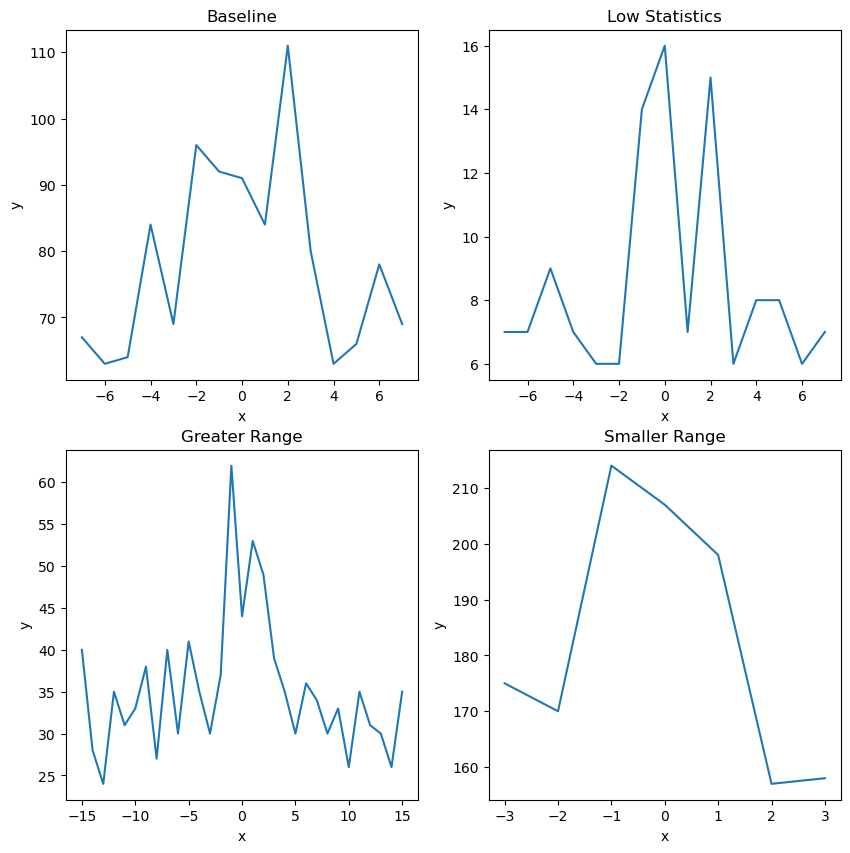

In [8]:
# Plotting the signal and background
#
# 
# YOUR CODE HERE
# 
A_true = 1
B_true = 2
x_0 = 0.
w = np.sqrt(5)
x_k = np.linspace(-20, 20, 1000)
n_0 = 10

plt.plot(x_k, exact_data(A_true, B_true, n_0, x_k, x_0, w))
plt.title('True signal and background')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# The data has been generated already and will be loaded from a pickle file.
# It is a dictionary with four keys corresponding to the four cases, and each value
# corresponding to xk_pts, Dk_pts, Nk_pts, x_max, n_0
with open(f'{DATA_DIR}/PS2_Prob5_data.pickle','rb') as f:
    data = pickle.load(f)
    print('Loaded "data" dictionary from file.')
    print('Extract data with:')
    print('xk_pts, Dk_pts, Nk_pts, x_max, n_0 = data[case]')
    print('where the key "case" is one of:')
    cases = data.keys()
    print(cases)

# Plotting the data for the four cases
#
# 
# YOUR CODE HERE
# 
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].plot(data['Baseline'][0], data['Baseline'][2])
ax[0][0].set_title('Baseline')
ax[0][1].plot(data['Low Statistics'][0], data['Low Statistics'][2])
ax[0][1].set_title('Low Statistics')
ax[1][0].set_title('Greater Range')
ax[1][0].plot(data['Greater Range'][0], data['Greater Range'][2])
ax[1][1].set_title('Smaller Range')
ax[1][1].plot(data['Smaller Range'][0], data['Smaller Range'][2])
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('y')
ax[1][0].set_xlabel('x')
ax[1][0].set_ylabel('y')
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('y')
ax[1][1].set_xlabel('x')
ax[1][1].set_ylabel('y')
plt.show()

### (a) Compute and plot the joint posterior on a grid
**Tasks**
* Implement functions for the (log) likelihood. Let's use a uniform prior for $0 \le A \le 5$ and $0 \le B \le 5$.
* Evaluate the log-posterior on a grid and then: 
  - Plot the joint posterior pdf for $A$ and $B$ for the four cases.
  - Plot the marginalized posterior pdf for the signal amplitude $A$ for the four cases.
  
  Use the same axis scales for all four cases such that the precision of the inference can be compared.

In [9]:
# Define the pdfs and combine with Bayes' theorem.

def log_prior(A, B):
    """
    Log prior .
    
    We take a uniform (flat) prior with large enough
    maximums but, more importantly, require positive values for A and B.
    """
    A_max = 5.
    B_max = 5.
    # flat prior 
    if np.logical_and(A <= A_max, B <= B_max).all(): 
        return np.log(1/(A_max * B_max))
    else:
        return -np.inf


def log_likelihood(A, B, xk_pts, Nk_pts, n_0):
    """Log likelihood for data Nk_pts given A and B"""
    # 
    # YOUR CODE HERE
    # 
    #Bayesian linear regression
    A = A.ravel()
    B = B.ravel()
    log_likelihood = np.zeros_like(A)
    D_k = np.zeros((np.shape(A)[0],np.shape(xk_pts)[0]))
    Nk_pts_fac = np.zeros_like(Nk_pts)
    for i in range(len(Nk_pts)):
        for j in range(Nk_pts[i]):
            Nk_pts_fac[i] += np.log(j+1)
        
    for i in range(np.shape(A)[0]):
        D_k[i,:] = exact_data(A[i], B[i], n_0, xk_pts, x_0=0., width=np.sqrt(5.))
        log_likelihood[i] = np.sum(Nk_pts*np.log(D_k[i]) - D_k[i] - Nk_pts_fac)            
    return log_likelihood
    
def log_posterior(A, B, xk_pts, Nk_pts, n_0):
    """Log posterior for data Nk_pts given A and B"""
    return log_prior(A, B) + log_likelihood(A, B, xk_pts, Nk_pts, n_0)

# Other utility code can be put here (if needed)
#
# 
# YOUR CODE HERE
# 

C:\Users\elsaz_6\AppData\Local\Temp\ipykernel_4220\3905333933.py:36: RuntimeWarning: divide by zero encountered in log
  log_likelihood[i] = np.sum(Nk_pts*np.log(D_k[i]) - D_k[i] - Nk_pts_fac)


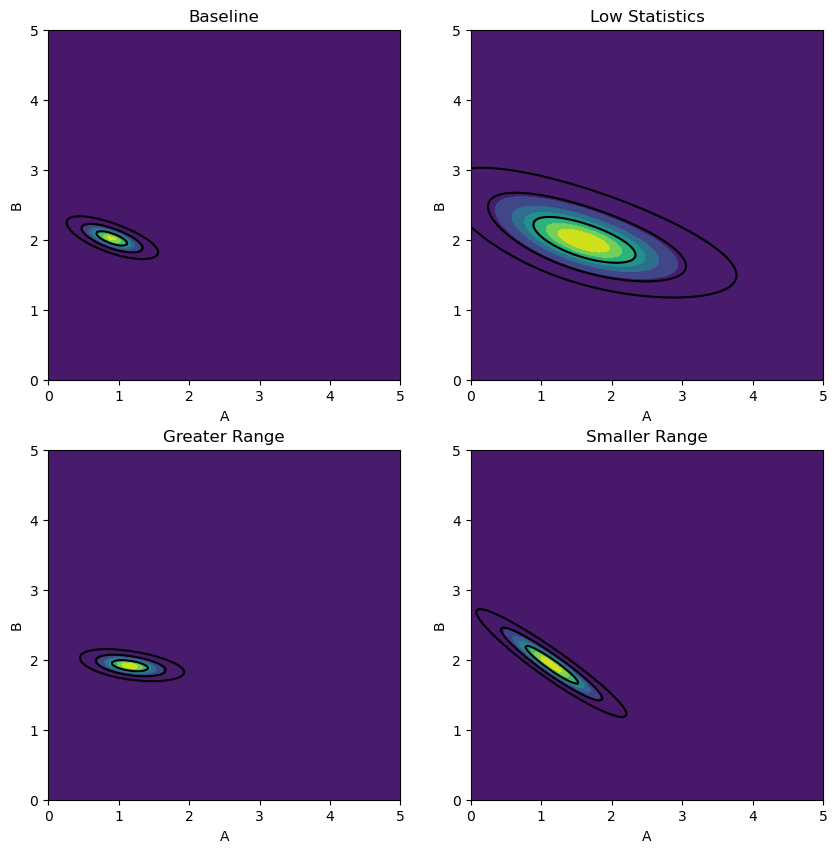

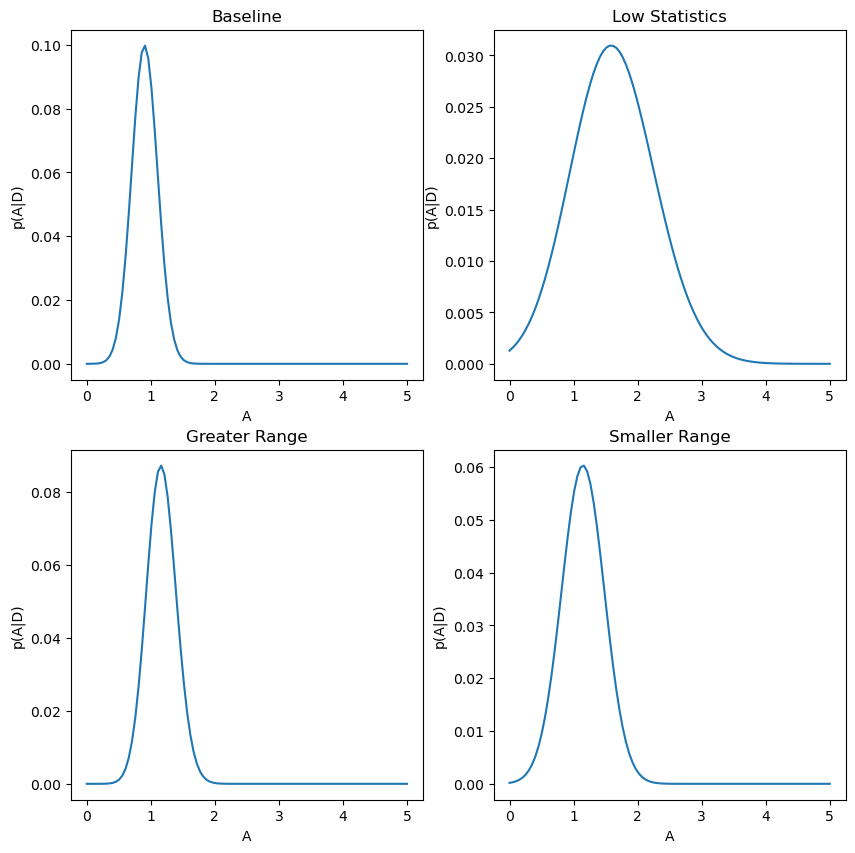

In [10]:
# Optional.
# Code to find contour levels of gridded 2D posterior.

def find_contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior
       Note: taken from BayesianAstronomy but may not work here.
    """
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return np.sort(sorted_[cutoffs])

# 
# YOUR CODE HERE
# 
alpha = np.linspace(0, 5, 100)
beta = np.linspace(0, 5, 200)
A, B = np.meshgrid(alpha, beta)
w = np.sqrt(5)

fig, ax = plt.subplots(2,2, figsize=(10,10))
fig2, ax2 = plt.subplots(2,2, figsize=(10,10))
plots = ['Baseline', 'Low Statistics', 'Greater Range', 'Smaller Range']
#plots = ['Smaller Range']
for i, name in enumerate(plots):
    xk_pts = np.array(data[name][0])
    Nk_pts = np.array(data[name][2])
    n_0 = data[name][4]
    log_pos = log_posterior(A, B, xk_pts, Nk_pts, n_0).reshape(200, 100)
    pos = np.exp(log_pos)
    norm = np.trapezoid(pos, axis=0)
    norm = np.trapezoid(norm)
    pos /= norm
    col = i//2
    row = i%2
    ax[col][row].contourf(A, B, pos)
    ax[col][row].contour(A, B, pos, find_contour_levels(pos), colors='black')
    ax[col][row].set_title(name)
    ax[col][row].set_xlabel('A')
    ax[col][row].set_ylabel('B')
    #print(pos_A)
    pos_A = np.sum(pos, axis=0)
    norm = np.trapezoid(pos_A)
    pos_A /= norm
    ax2[col][row].plot(alpha, pos_A)
    ax2[col][row].set_title(name)
    ax2[col][row].set_xlabel('A')
    ax2[col][row].set_ylabel('p(A|D)')
plt.show()



### (b) Design of experiment
**Tasks** 
Answer the following questions. You can use the markdown cell below.
  1. Can you understand why the signal and background amplitudes are anticorrelated? And why the (anti)correlation seems to be stronger in one of the cases? 
  1. What are your conclusions for how to design the experiment given limited resources? 
    - In particular, given that you wanted to be able to distinguish between signal amplitude and background, would it then be better to have many counts in few bins, or the same total amount of counts spread over a wider interval? 

**Write your answer here**

1. The signal and background are anticorrelated because if one of them is larger, the other one must be smaller in order to achive the same results. The anticorrelation is stronger for the small range, since the exponant for the signal becomes smaller for a smaller range, which results in a more linear expression. 
2. To be able to distinguish between amplitude and background, it would be better to have a wider interval to spread the counts over, as the greater range data provided much smaller uncertainty in both parameters with the same total amount of counts as the smaller range. 

In [11]:
#Ignore this cell. No code is needed here.
#
# 
# YOUR CODE HERE
# 

## Problem 6: Good-data, bad-data
### Task (a): 3 points; Task (b): 1 point

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

Let's start by defining some data that we will fit with a straight line.  The following data is measured velocities and distances for a set of galaxies. We will assume that there is an observational error on the $y$ values (and no error on $x$). 
- These errors are considered as independent and identically distributed (i.i.d.) from a normal distribution with mean 0.0 and standard deviation $\sigma = 200$ km/sec.
- However, as seen in the data table below, it turns out that two of the measurements resulted in "bad data" with errors that are much larger than what could be expected from the assumed error model. 

In [13]:
# Data from student lab observations; 
# x = Galaxy distances in MPc
# y = Galaxy velocity in km/sec
x = np.array([10.1 ,45.2, 19.7, 31.2, 31.9, 44.0,
       14.9, 35.1,  39.9  ])
y = np.array([1507.9, 2937.5,  930.4, 2037.1, 2131.1,
       2795.6, 1061.8, 2464.8, 
       1971.1])
# Two of these samples, the 10.1 and 39.9 data points, were added by hand.
# They are rather extreme samples from a Cauchy distribution with the same FWHM and 
# could be assumed to come from an experiment where some systematic error was missing from the analysis
# (here leading the experimentalists to assign a Gaussian error when in fact it should have been Lorenzian).

intercept = 0.
slope = 70
theta_true = [intercept, slope]

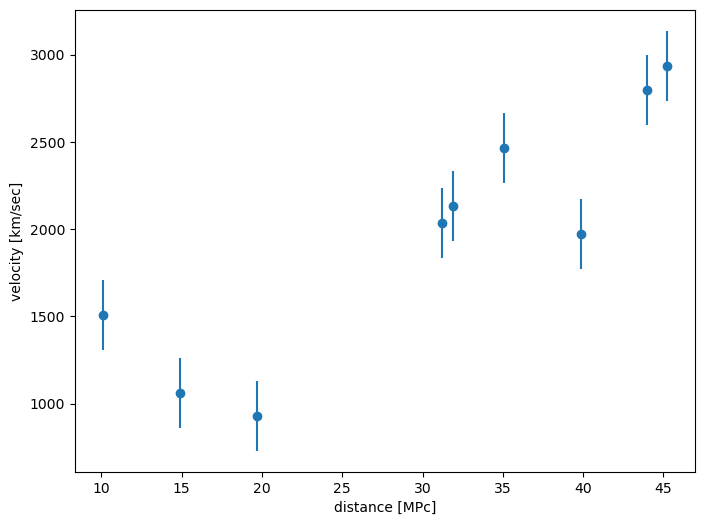

In [14]:
# Plot the data with the assumed error model indicated by a standard deviation
dy=200
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel(r'distance [MPc]')
ax.set_ylabel(r'velocity [km/sec]');

### Task (a)

The question that we will be asking is: 
> What value would you infer for the Hubble constant, i.e. the slope of the velocity versus distance relation, given this data?

We will make the prior assumption that the data can be fitted with a straight line. But we note that we are actually not interested in the offset of the straight line, but just its slope.

We will try three different approaches:
1. Maximum likelihood estimate
1. Bayesian analysis
1. Bayesian analysis incorporating a Bayesian approach to identify "good-data-bad-data"

As a second task, we will also explore how the posterior belief from this analysis can feed into a subsequent data analysis.

#### Statistical model
Here we are given data with simple error bars (constant $\sigma$), which implies that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma),
$$

with $y_M(x) = mx + b$.
Or, in other words,

$$
p(y_i\mid\theta) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\sigma^2}\right)
$$

where $\sigma$ is the (known) measurement error indicated by the error bars.

ps Note that the assignment of normally distributed experimental errors is incorrect for two of the data points, but we don't know that (yet).

#### Step 1: Maximum likelihood estimate

Perform a maximum likelihood estimate of the slope and the intercept. 
- Use `optimize.minimize` from `scipy` to find the maximum of the log likelihood.
- Estimate an uncertainty by extracting the inverse of the Hessian (second derivative of the log likelihood) at the optimum. Note that the result from `optimize.minimize` will have a property `hess_inv`. 

In [15]:
# Maximum likelihood estimate (MLE)
#
# The parameter vector theta = [intercept, slope]
# Assign the two arrays with the MLE estimate and the diagonal elements of the inverse hessian
theta_MLE = np.array([0.,0.])
err_theta_MLE = np.array([0.,0.])

# 
# YOUR CODE HERE
# 
def log_likelihood(theta):
    X = np.column_stack((np.ones_like(x), x))
    log_likelihood = -1/2*np.log(2*np.pi*dy*dy) - 1/(2*dy*dy)*(y - X@theta).T@(y-X@theta)
    return log_likelihood

m = np.linspace(-100, 100, 100)
k = np.linspace(-100, 100, 100)
theta_0 = np.array([-10, 0])

max_likelihood = scipy.optimize.minimize(log_likelihood, theta_0)
print(max_likelihood)
theta_MLE = max_likelihood.x
err_theta_MLE[0] = max_likelihood.hess_inv[0][0]
err_theta_MLE[0] = max_likelihood.hess_inv[1][1]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -143349.98649013083
        x: [-4.065e+01 -1.034e+03]
      nit: 1
      jac: [ 7.484e+00  2.610e+02]
 hess_inv: [[ 9.955e-01 -1.532e-01]
            [-1.532e-01 -4.200e+00]]
     nfev: 348
     njev: 112


In [16]:
assert not (theta_MLE==0).all(), f'The theta_MLE array should contain the MLE estimate: {theta_MLE}'
assert not (err_theta_MLE==0).all(), 'The err_theta_MLE array should contain the MLE error estimate'


#### Step 2: Bayesian analysis
For the Bayesian analysis we would recommend a Gaussian prior (mean=0, standard deviation=$\sigma = 200$ km/sec) for the intercept, and a symmetric prior
$$
p(m|I) \propto \frac{1}{(1+m^2)^{3/2}}
$$
for the slope (the latter was used also in the fitting straight line example).

- Check the trace of the MCMC sampling to make sure (visually) that you use a proper warmup period. 
- Plot the samples using the `corner` package and extract the median and 68% credibility region for the slope parameter using the marginalized distribution.
- Use the parameter samples to create corresponding samples of our model predictions. Show the model prediction together with the data by plotting (i) the prediction using the median, point estimate for the parameters as well as (ii) a filled band corresponding to the  68% credibility region of these sampled predictions.

In [17]:
# Define the log prior and the log posterior
#
# 
# YOUR CODE HERE
# 
def log_prior(theta):
    sigma = 200
    log_prior_b = np.log(1/(np.sqrt(2*np.pi*sigma*sigma))) - (theta[0])*(theta[0])/(2*sigma*sigma)
    log_prior_m = -3/2*np.log(1+theta[1]*theta[1])
    return log_prior_b + log_prior_m

def log_posterior(theta):
    return log_prior(theta) + log_likelihood(theta)

In [18]:
# Perform MCMC sampling using emcee
#
# 
# YOUR CODE HERE
# 
N_walkers = 10  
sampler = emcee.EnsembleSampler(N_walkers, 2, log_posterior)
theta_start = np.random.rand(N_walkers,2)
sampler.run_mcmc(theta_start, 1000)
samples = sampler.get_chain(flat=True)

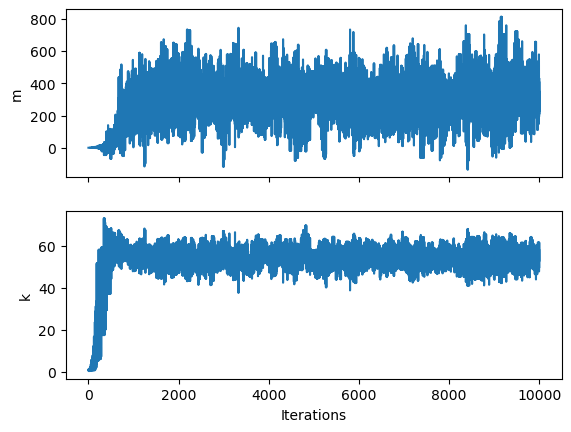

In [19]:
# Our choice of starting points were not optimal. It takes some time for the MCMC chains 
# to converge. We recommend to study the traces.
#
# 
# YOUR CODE HERE
# 
x_p = np.arange(10000)
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(x_p, samples[:,0])
ax[1].plot(x_p, samples[:,1])
ax[1].set_xlabel('Iterations')
ax[0].set_ylabel('m')
ax[1].set_ylabel('k')
plt.show()

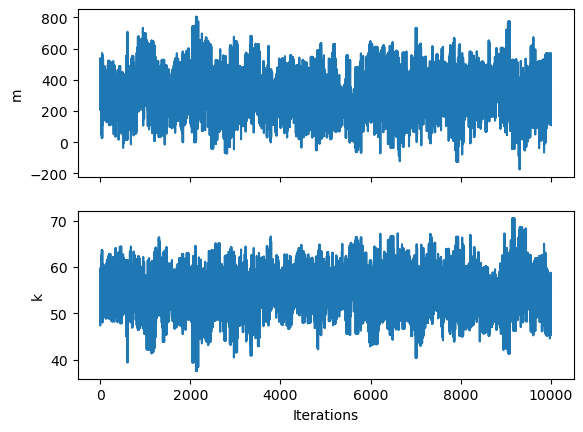

In [20]:
# And choose an appropriate warm-up time
nwarmup = 100 # update this!

# we'll throw-out the warmup points, collect the chains from all walkers, 
# and reshape into an array 'samples' of shape (nsamples, 2)
samples=np.array([])

# 
# YOUR CODE HERE
# 
sampler.reset()
theta_start = np.random.rand(N_walkers,2)
theta_burnin = sampler.run_mcmc(theta_start, nwarmup)
sampler.reset()
sampler.run_mcmc(theta_burnin, 1000)
samples = sampler.get_chain(flat=True)
x_p = np.arange(10000)
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(x_p, samples[:,0])
ax[1].plot(x_p, samples[:,1])
ax[1].set_xlabel('Iterations')
ax[0].set_ylabel('m')
ax[1].set_ylabel('k')
plt.show()

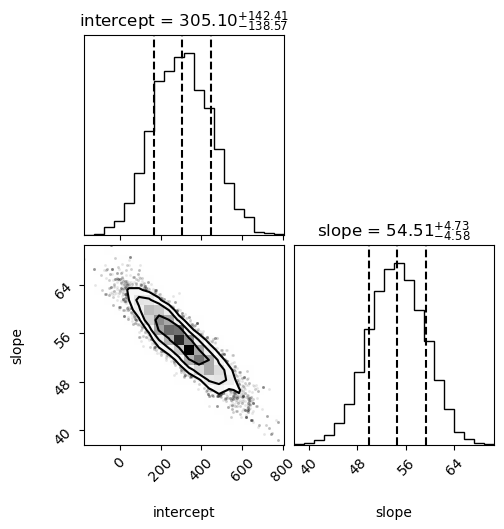

In [21]:
# Plot the samples using the `corner` package and extract the median and 
# 68% confidence region for the slope parameter
# 
# YOUR CODE HERE
# 
corner.corner(samples,labels=["intercept", "slope"],show_titles=True,
                       quantiles=[0.16, 0.5, 0.84],);
quantile_slope = corner.quantile(samples[:,1], [0.16, 0.5, 0.84])
quantile_intercept = corner.quantile(samples[:,0], [0.16, 0.5, 0.84])

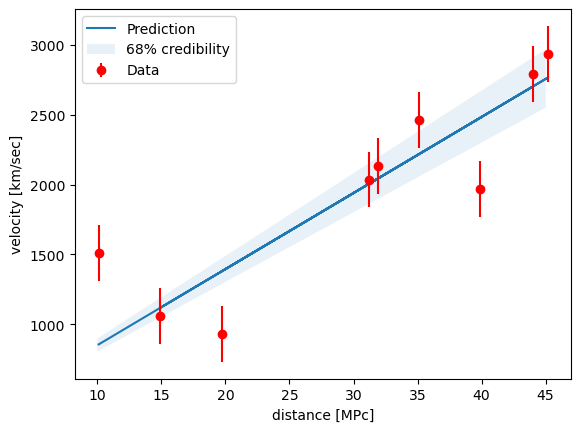

In [22]:
# We can use the parameter samples to create corrsponding samples of our model predictions. 
# Plot the prediction using the median, point estimate for the parameters 
# as well as a filled band corresponding to the  68% credibility region of these sampled predictions.

# 
# YOUR CODE HERE
# 
m = quantile_intercept[1]
k = quantile_slope[1]
def f(x, m, k):
    return m + k*x

x_plot = np.linspace(10, 45, 2)

def find_contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior
       Note: taken from BayesianAstronomy but may not work here.
    """
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.16, 0.84]) ** 2)
    return np.sort(sorted_[cutoffs])

plt.plot(x, f(x, m, k), label='Prediction')
plt.errorbar(x, y, dy, fmt='o', color='red', label='Data')
plt.xlabel(r'distance [MPc]')
plt.ylabel(r'velocity [km/sec]')
plt.fill_between(x_plot, f(x_plot, quantile_intercept[1], quantile_slope[0]), f(x_plot, quantile_intercept[1], quantile_slope[2]), alpha=0.1, label='68% credibility')
plt.legend()
plt.show()

#### Step 3: Bayesian Approach to Outliers (good-data/bad-data)

There are several Bayesian approaches to accounting for outliers. They generally involve *modifying the statistical model*. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers where the experimental error bar might have been underestimated. 

Specifically we will assume that there is a chance that the error distribution is represented by a Lorentzian distribution rather than a Gaussian. The peaks of these two distributions are very similar in shape, but the Lorentzian has much heavier tails.

We will use a statistical model in which we allow each individual data point $(x_i,y_i)$ to be described by
a mixture between a Gaussian and a Lorentzian error model: 

$$
\begin{array}{ll}
p(\{y_i\}~|~\theta,\{g_i\},\sigma) = & g_i \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left[\frac{-\left(y_M(x_i~|~\theta) - y_i\right)^2}{2\sigma^2}\right] \\
&+ (1 - g_i) \frac{1}{\sqrt{2}\pi \sigma} \frac{1}{1 + \left[ y_M (x_i~|~\theta) - y_i\right]^2 / (2\sigma^2)}
\end{array}
$$

What we've done is expanded our model with some nuisance parameters, $\{g_i\}$, that is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the different error models. 

Our model is much more complicated now: it has one new parameter per data point, but these can be considered nuisance parameters that can be marginalized-out in the end.  You can use a uniform prior $U(0,1)$ for these parameters. For the theoretical model we would recommend a Gaussian prior (mean=0, standard deviation $= \sigma = 200$ km/sec) for the intercept, and a symmetric prior
$$
p(m|I) \propto \frac{1}{(1+m^2)^{3/2}}
$$
for the slope.

- Your task is to implement this likelihood and to use, e.g., the [emcee](http://dan.iel.fm/emcee/current/) MCMC package to explore the parameter space.
- Display the joint posterior for the slope and the intercept using a corner plot (i.e. marginalize over the g-parameters). 
- Extract the median and 68% credibility region for the slope parameter using the marginalized distribution.
- Finally, study the posterior distribution for the g-parameters. Can you conclude which data points are more likely to be outliers (i.e. underestimated tails of the error distribution)?

In [23]:
# Implement the log prior, likelihood, posterior
#

# 
# YOUR CODE HERE
# 
def log_prior_outliers(theta):
    sigma = 200
    log_prior_b = np.log(1/(np.sqrt(2*np.pi*sigma*sigma))) - (theta[0])*(theta[0])/(2*sigma*sigma)
    log_prior_m = -3/2*np.log(1+theta[1]*theta[1])
    if 0<=np.all(theta[2:]) and np.all(theta[2:])<=1: 
        log_prior = log_prior_b + log_prior_m
    else:
        log_prior = -np.inf
    return log_prior

def log_likelihood_outliers(theta):
    X = np.column_stack((np.ones_like(x), x))
    if all(0<= th <= 1 for th in theta[2:]):
        log_likelihood = 0
        for i in range(len(y)):
            likelihood_out = theta[2+1]/(np.sqrt(2*np.pi)*dy)*np.exp(-1/(2*dy*dy)*(y[i] - X[i]@theta[:2])*(y[i]-X[i]@theta[:2])) + (1-theta[2+i])*1/(np.sqrt(2)*np.pi*dy)*1/(1+1/(2*dy*dy)*(y[i] - X[i]@theta[:2])*(y[i]-X[i]@theta[:2]))
            log_likelihood += np.log(likelihood_out)
        return log_likelihood
    else:
        return -np.inf

def log_posterior_outliers(theta):
    return log_prior_outliers(theta) + log_likelihood_outliers(theta)

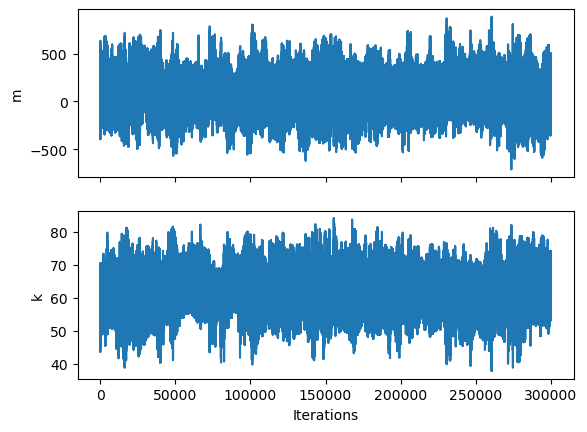

In [24]:
# Perform the MCMC sampling
#
# Note that this step can be computationally costly. For the submitted version you are encouraged 
# to use less than 10,000 samples for each walker (and no more than 50 walkers)

# 
# YOUR CODE HERE
# 

N_walkers = 30  
sampler = emcee.EnsembleSampler(N_walkers, 11, log_posterior_outliers)
theta_start = np.random.rand(N_walkers, 11)
theta_burnin = sampler.run_mcmc(theta_start, 3000)
sampler.reset()
sampler.run_mcmc(theta_burnin, 10000)
samples = sampler.get_chain(flat=True)

x_p = np.arange(300000)
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(x_p, samples[:,0])
ax[1].plot(x_p, samples[:,1])
ax[1].set_xlabel('Iterations')
ax[0].set_ylabel('m')
ax[1].set_ylabel('k')
plt.show()

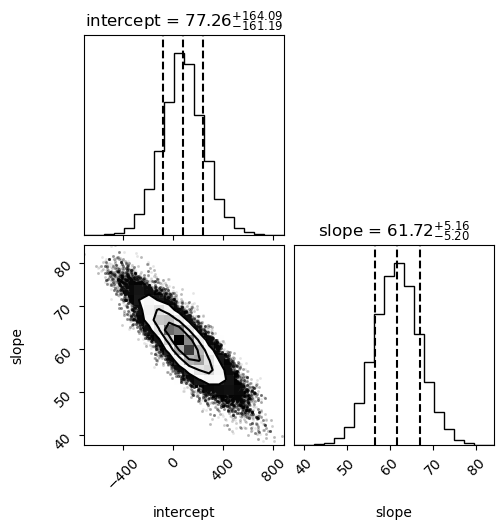

In [25]:
# Corner plot for the intercept and slope parameters
#

# 
# YOUR CODE HERE
# 
#print(np.trapezoid(samples[:, :], samples[2]))
corner.corner(samples[:,:2],labels=["intercept", "slope"],show_titles=True,
                       quantiles=[0.16, 0.5, 0.84],);

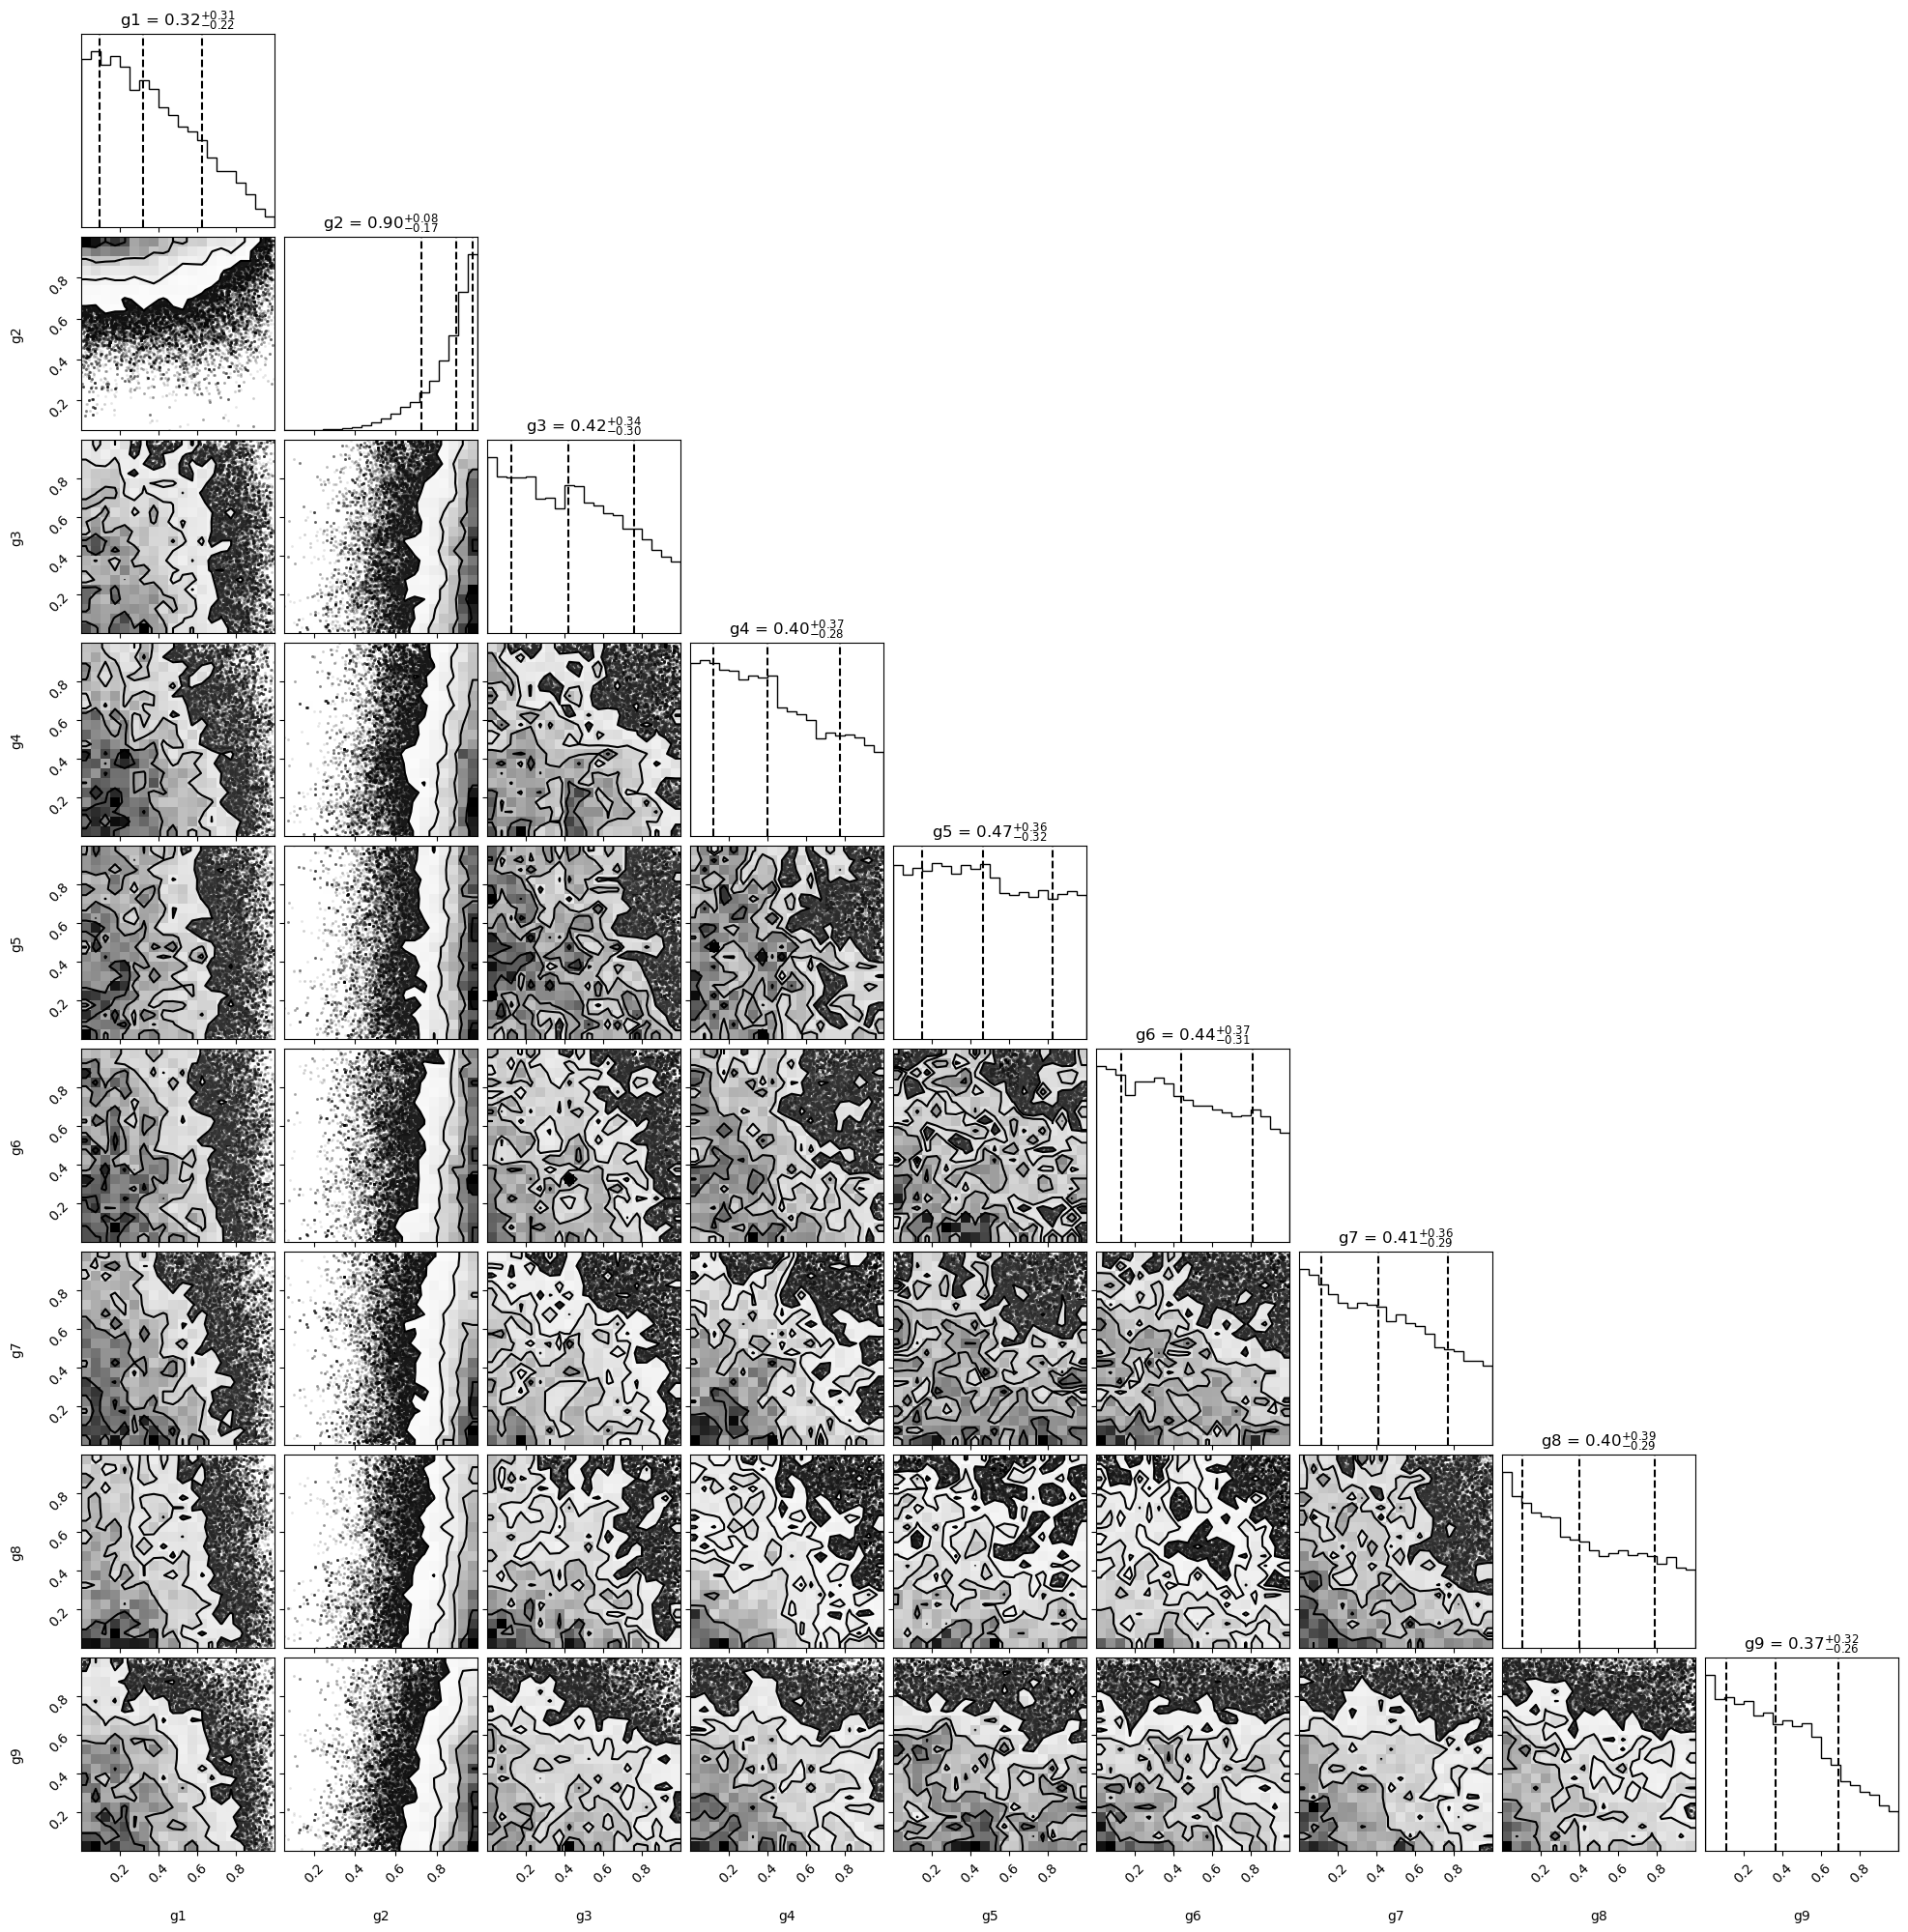

In [26]:
# Plot the posterior joint pdf for the g-parameters (using a corner plot)
#
# 
# YOUR CODE HERE
# 
corner.corner(samples[:,2:],labels=["g1", "g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9"],show_titles=True,
                       quantiles=[0.16, 0.5, 0.84],);

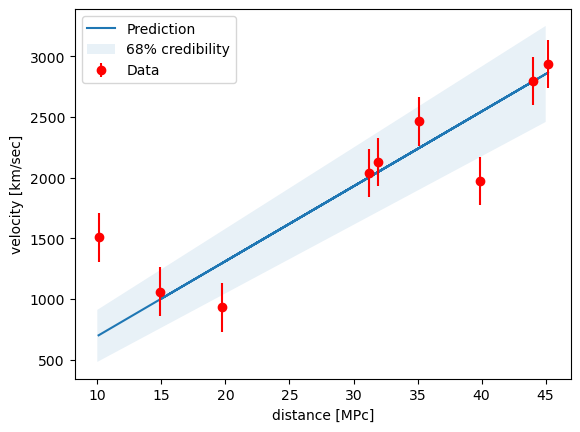

The data point with distance 10.1 and 39.9 are most likely the outliers.


In [27]:
# Which data points are most likely outliers?
#
# 
# YOUR CODE HERE
# 
x_plot = np.linspace(10, 45, 2)
quantile_slope = corner.quantile(samples[:,1], [0.16, 0.5, 0.84])
quantile_intercept = corner.quantile(samples[:,0], [0.16, 0.5, 0.84])
plt.plot(x, f(x, quantile_intercept[1], quantile_slope[1]), label='Prediction')
plt.errorbar(x, y, dy, fmt='o', color='red', label='Data')
plt.xlabel(r'distance [MPc]')
plt.ylabel(r'velocity [km/sec]')
plt.fill_between(x_plot, f(x_plot, quantile_intercept[0], quantile_slope[0]), f(x_plot, quantile_intercept[2], quantile_slope[2]), alpha=0.1, label='68% credibility')
plt.legend()
plt.show()
print('The data point with distance 10.1 and 39.9 are most likely the outliers.')

### Task (b): Error propagation

The Bayesian approach offers a straight-forward approach for dealing with (known) systematic uncertainties; namely by marginalization.

The Hubble constant acts as a galactic ruler as it is used to measure astronomical distances according to $v = H_0 x$. An error in this ruler will therefore correspond to a systematic uncertainty in such measurements.

Suppose that a particular galaxy has a measured recessional velocity $v_\mathrm{measured} = (100 \pm 5) \times 10^3$ km/sec. Also assume that the Hubble constant $H_0$ is known from the analysis performed above in Step 3. Determine the posterior pdf for the distance to the galaxy assuming:
1. A fixed value of $H_0$ corresponding to the posterior mean of the previous analysis.
1. Using the full, sampled posterior pdf for $H_0$ from the same analysis.

In this analysis we will set the intercept $m=0$ so that $v_\mathrm{theory} = H_0 x$.

In [28]:
vm=100000
sig_vm=5000

We assume that we can write
$$
v_\mathrm{measured} = v_\mathrm{theory} + \delta v_\mathrm{exp},
$$
where $v_\mathrm{theory}$ is the recessional velocity according to our model, and $\delta v_\mathrm{exp}$ represents the noise component of the measurement. We that $\delta v_\mathrm{exp}$ can be described by a Gaussian pdf with mean 0 and standard deviation $\sigma_v = 5 \times 10^3$ km/sec. Note that we have also assumed that our model is perfect, i.e. $\delta v_\mathrm{theory}$ is negligible.

In the following, we also assume that the error in the measurement in $v$ is uncorrelated with the uncertainty in $H_0$.

Through application of Bayes' rule we can readily evaluate the posterior pdf $p(x|D,I)$ for the distance $x$ to the galaxy.

#### Case 1: Fixed $H_0$

\begin{align}
p(x | D,I) & \propto p(D | x, I) p(x|I) \\
& = \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - v_\mathrm{theory})^2}{2\sigma_v^2} \right) p(x|I)\\
&= \left\{ \begin{array}{ll} \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - H_0 x)^2}{2\sigma_v^2} \right) & \text{with }x \in [x_\mathrm{min},x_\mathrm{max}] \\
0 & \text{otherwise},
\end{array} \right.
\end{align}


where $p(x|I)$ is the prior for the distance which we have assumed to be uniform, i.e. $p(x|I) \propto 1$ in some (possibly large) region $[x_\mathrm{min},x_\mathrm{max}]$.

In [29]:
# Find the median value for H
#
# 
# YOUR CODE HERE
# 

#### Case 2: Using the inferred pdf for $H_0$

Here we use marginalization to obtain the desired posterior pdf $p(x|D,I)$ from the joint distribution of $p(x,H_0|D,I)$
$$
p(x|D,I) = \int_{-\infty}^\infty dH_0 p(x,H_0|D,I).
$$

Using Bayes' rule, the product rule, and the fact that $H_0$ is independent of $x$ we find that
$$
p(x|D,I) \propto p(x|I) \int dH_0 p(H_0|I) p(D|x,H_0,I),
$$
which means that we have expressed the quantity that we want (the posterior for $x$) in terms of quantities that we know.

The pdf $p(H_0 | I)$ is known via its $N$ samples $\{H_{i}\}$ generated by the MCMC sampler.

This means that we can approximate 
$$
p(x |D,I) = \int dH_0 p(H_0|I) p(D|x,H_0,I) \approx \frac{1}{N} \sum_{i=1}^N p(D | x, H_i, I)
$$
where we have used $p(x|I) \propto 1$.

In [30]:
# Infer the distance using the two different approaches (point estimate for H_0, and using the full pdf for H_0)
#
# 
# YOUR CODE HERE
# 